Dataset shape: (32561, 15)
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country   Class  
0          2174             0            

C:\Users\st\AppData\Local\Temp\ipykernel_9120\1676509612.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)
C:\Users\st\AppData\Local\Temp\ipykernel_9120\1676509612.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

X_scaled shape: (32561, 105)
Resampled X_train shape: (39556, 105)
Resampled y_train shape: (39556,)
Accuracy: 0.8462
Confusion Matrix:
[[4376  566]
 [ 436 1135]]
Precision Score (weighted): 0.850986952492448
Recall Score (weighted): 0.8461538461538461
F1 Score (weighted): 0.8481848604502816
ROC AUC Score: 0.8987


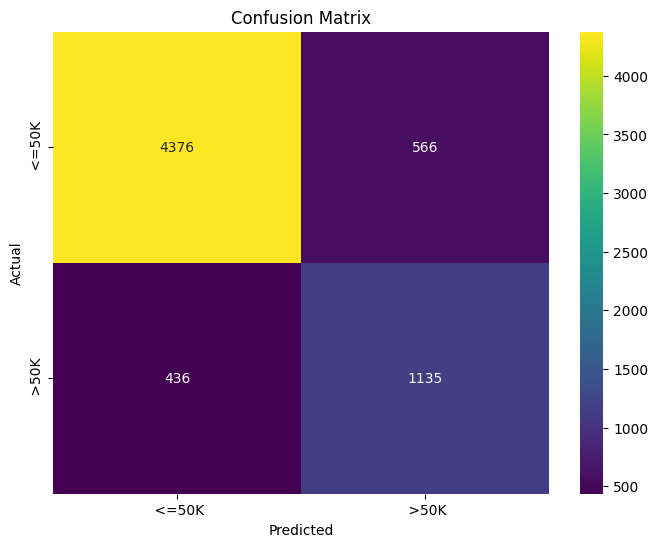

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters from Randomized Search: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE  # For oversampling the minority class
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"d:\4th semester\Programming for AI\adult.data"
data = pd.read_csv(file_path, header=None)

# Assign column names
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "Class"
]
data.columns = columns


print(f"Dataset shape: {data.shape}")
print(data.head())

# Handle missing values 
data.replace(' ?', np.nan, inplace=True)
for column in data.columns:
    if data[column].dtype == 'object':  
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  
        data[column].fillna(data[column].mean(), inplace=True)

# Features and target separation
X = data.drop('Class', axis=1)
y = data['Class']


# Convert categorical features to numeric using OneHotEncoder
categorical_cols = X.select_dtypes(include=['object']).columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Use sparse=False for XGBoost
X_encoded = pd.DataFrame(ohe.fit_transform(X[categorical_cols]))
X_encoded.columns = ohe.get_feature_names_out(categorical_cols)

# Drop original categorical columns and concatenate the new encoded features
X = X.drop(categorical_cols, axis=1)
X = pd.concat([X, X_encoded], axis=1)

#  Label Encoding 
le = LabelEncoder()
y = le.fit_transform(y)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"X_scaled shape: {X_scaled.shape}")

#  Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# class balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"Resampled y_train shape: {y_train_resampled.shape}")

# Random Forest Model 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)


y_pred = rf.predict(X_test)

# Model Evaluation

accuracy = rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Precision, Recall, F1 Score
print("Precision Score (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

# ROC AUC Score and Curve
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plotting the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Apply RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='roc_auc',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=2
)


random_search.fit(X_train_resampled, y_train_resampled)


print(f"suitable Parameters from Randomized Search: {random_search.best_params_}")




In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV



param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10,  None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=2
)


grid_search.fit(X_train_resampled, y_train_resampled)


print(f"Best Parameters from Grid Search: {grid_search.best_params_}")


Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\st\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\st\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\st\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

Best Parameters from Grid Search: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
